# Unbinned Datasets - Taylored approach


##  Load Module

In [401]:
%matplotlib inline
import gammapy
print(gammapy.__version__)

import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import astropy.units as u
from scipy import integrate , interpolate

from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from astropy.coordinates import SkyCoord, Angle
from astropy.utils import lazyproperty
from regions import CircleSkyRegion
from gammapy.data import DataStore, Observation, EventList
from gammapy.datasets import MapDataset, MapDatasetEventSampler, SpectrumDataset
from gammapy.estimators import LightCurveEstimator
from gammapy.maps import MapAxis, WcsGeom, Map, MapAxes, WcsNDMap, RegionGeom
from gammapy.irf import load_cta_irfs
from gammapy.makers import MapDatasetMaker, FoVBackgroundMaker, SafeMaskMaker, SpectrumDatasetMaker, ReflectedRegionsBackgroundMaker
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Model,
    Models,
    SkyModel,
    PowerLawSpectralModel,
    PowerLawNormSpectralModel,
    PointSpatialModel,
    TemplateSpatialModel,
    ExpDecayTemporalModel,
    LightCurveTemplateTemporalModel,
    FoVBackgroundModel,
    GaussianSpatialModel,
    LogParabolaSpectralModel,
    DatasetModels,
    ExpCutoffPowerLawSpectralModel
)
# from utils import EdispInv

0.20.1


### Custom functions

In [402]:
def build_true_ra_dec_and_offset( observation, events=None, etrue=None):
    if events is None:
        events=  observation.events
        
    radec      =  events.radec
    
    # CENTER ON POINTING
    #center      =obs1.pointing_radec
    #CENTER ON EVENT
    center      =  radec 

    
    # CARTESIAN GRID
    offsets        = radec.separation( observation.pointing_radec) 
    #cont_rad      =  np.array( [ np.max( cont_radius_interp(e , o) ) for e,o in zip( etrue, offsets)])
    cont_rad       =  np.array( [cont_radius_interp(etrue[:,k,0,0] , offsets).diagonal() for k in range( etrue.shape[1]) ] )
    separation     =  np.linspace(-cont_rad,cont_rad,16) * u.deg
    #true_ra_dec    = center.directional_offset_by( separation = separation[None,:,None], position_angle=0*u.deg)
    #true_ra_dec    = true_ra_dec.directional_offset_by( separation = separation[None,None,:], position_angle=90*u.deg)
    true_radec    = center.directional_offset_by( separation = separation, position_angle=0*u.deg)
    true_radec    = true_radec.directional_offset_by( separation = separation[:,None,:], position_angle=90*u.deg)
    true_radec    = true_radec.T
    delta_ra      = true_radec[:,:,1:,1:].ra - true_radec[:,:,:-1,:-1].ra
    delta_dec     = true_radec[:,:,1:,1:].dec - true_radec[:,:,:-1,:-1].dec
    delta_Omega   = delta_ra * delta_dec
    
    true_radec    = true_radec[:,:,:-1,:-1]

    
    
    rad                   =   true_radec.separation( radec[:,None,None,None] ) 
    true_offset           =   true_radec.separation( observation.pointing_radec) 
    
    return true_radec, delta_Omega, rad, true_offset 


def build_true_energy( observation,events=None):
    if events is None:
        events=  observation.events
        
    ereco_events       =  events.energy
    
    edisp                  = observation.edisp
    edisp.normalize()
    
    migra_min , migra_max  = edisp.axes['migra'].bounds.value
    etrue                  = np.geomspace( ereco_events/ migra_max, ereco_events/ migra_min ,11)
    etrue                  = etrue.T
    delta_etrue            = np.diff(etrue,axis=1)
    etrue                  = etrue[:,1:]
    
    return etrue[:,:,None,None], delta_etrue[:,:,None,None]


def make_edisp_factors(observation, true_offset, etrue,events=None):
    if events is None:
        events=  observation.events
        
    ereco_events       =  events.energy[:,None,None,None]
    
    edisp2D        = observation.edisp
    edisp2D.normalize()
    edisp        =  edisp2D.evaluate( 
                     offset =true_offset,
                     energy_true=etrue,
                     migra=ereco_events/etrue 
                    ) / etrue
    return edisp


def make_aeff_factors(observation, true_offset, etrue):
    
    aeff         = observation.aeff.evaluate(offset=true_offset , energy_true=etrue)
    return aeff

def make_psf_factors( observation, true_offset, etrue, rad):
    psf3d        = observation.psf
    psf3d.normalize()
    
    psf_factors = psf3d.evaluate(
                    energy_true=etrue, 
                    rad=rad, 
                    offset=true_offset
                ) 
    
    return psf_factors


def convolve_irf(model, psf, edisp, aeff,  etrue, detrue, true_ra_dec, domega):#, drad):
    
    lon      = true_ra_dec.galactic.l
    lat      = true_ra_dec.galactic.b

    phi_true = model( energy= etrue , lon=lon, lat=lat  ) 
    phi_obs  = np.sum(  phi_true * aeff  * edisp * detrue *   psf_factors * domega   , axis=(1,2,3)) 
    return phi_obs
    

def convolve_irf2(spectral_model, edisp, aeff, etrue, detrue):
    return np.sum( edisp * spectral_model(etrue) * aeff * detrue  , axis=1)

### Load data

In [403]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")
np.unique( np.array( data_store.hdu_table['OBS_ID'] ))

array([20136, 20137, 20151, 20275, 20282, 20283, 20301, 20302, 20303,
       20322, 20323, 20324, 20325, 20326, 20327, 20339, 20343, 20344,
       20345, 20346, 20349, 20350, 20365, 20366, 20367, 20368, 20396,
       20397, 20421, 20422, 20517, 20518, 20519, 20521, 20561, 20734,
       20898, 20899, 20900, 20915, 21613, 21753, 21807, 21824, 21851,
       22022, 22593, 22997, 23040, 23077, 23143, 23246, 23523, 23526,
       23559, 23573, 23592, 23635, 23651, 23736, 25345, 25443, 25511,
       26077, 26791, 26827, 26850, 26964, 27044, 27121, 27939, 27987,
       28341, 28967, 28981, 29024, 29072, 29118, 29177, 29433, 29487,
       29526, 29556, 29683, 33787, 33788, 33789, 33790, 33791, 33792,
       33793, 33794, 33795, 33796, 33797, 33798, 33799, 33800, 33801,
       47802, 47803, 47804, 47827, 47828, 47829])

In [404]:
obs_id = [23523] # just one observation 
obs1 = data_store.get_observations(obs_id)[0]
obs1.events.table

EVENT_ID,TIME,RA,DEC,ENERGY
,s,deg,deg,TeV
int64,float64,float32,float32,float32
5407363825684,123890826.66805482,84.97964,23.89347,10.352011
5407363825695,123890826.69749284,84.54751,21.004095,4.0246882
5407363825831,123890827.23673964,85.39696,19.41868,2.2048872
5407363825970,123890827.79615426,81.93147,20.79867,0.69548655
5407363826067,123890828.26131463,85.98302,21.053099,0.86911184
5407363826095,123890828.41393518,86.97305,21.837437,4.1240892
5407363826128,123890828.52555823,83.40073,19.771587,1.6680022
5407363826168,123890828.6829524,82.25036,19.22003,4.7649446


### Create Dataset from observation

In [436]:
crab_pos = SkyCoord(184.507, -5.734, unit='deg', frame='galactic') 
obs_pos=obs1.pointing_radec
ebins = np.logspace(-1,2,49)
energy_axis = MapAxis.from_edges(
    ebins, unit="TeV", name="energy", interp="log"  
)
energy_axis_true = MapAxis.from_edges(
    ebins, unit="TeV", name="energy_true", interp="log"  
)
migra_axis = MapAxis.from_bounds(
    0.2, 5, nbin=160, node_type="edges", name="migra"
)
geom = WcsGeom.create(
    skydir=obs_pos,
    binsz=0.1,
    width=(5.5, 5.5),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)
geom_true = WcsGeom.create(
    skydir=obs_pos,
    binsz=0.1,
    width=(5.5, 5.5),
    frame="icrs",  # same frame as events
    proj="CAR",
    axes=[energy_axis_true],
)

circle = CircleSkyRegion(
    center=crab_pos, radius=0.3 * u.deg
)
data = geom.region_mask(regions=[circle], inside=False)
exclusion_mask = ~geom.region_mask(regions=[circle])
maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)


maker = MapDatasetMaker( selection=['psf','edisp','exposure','counts','background'],background_oversampling=2)
maker_safe_mask = SafeMaskMaker(methods=['offset-max'], offset_max='1.5 deg', bias_percent=8)
reference = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, migra_axis=migra_axis)  #, migra_axis=migra_axis

dataset = maker.run(reference, obs1)
dataset = maker_safe_mask.run(dataset, obs1)
dataset.mask_safe *= geom.energy_mask(energy_min=1*u.TeV)
# assert np.isfinite(dataset.background.data[dataset.mask_safe.data]).all()
# dataset.background.data[~dataset.mask_safe.data] = 0.0

#bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
#dataset.models=bkg_model

model_gauss = SkyModel(
        spatial_model=GaussianSpatialModel(lon_0="184.557 deg", lat_0="-5.784 deg", sigma='0.2 deg', frame = 'galactic'),

    spectral_model=LogParabolaSpectralModel(amplitude='3.5e-11 cm-2 s-1 TeV-1', 
                                          reference='1 TeV', 
                                          alpha=1.8, 
                                          beta=0.4
                                         ),
    name='crab_model_gauss'
    )


dataset.models = [model_gauss]

/Users/giacomodamico/opt/anaconda3/envs/gammapy-0.20/lib/python3.8/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


### Select events

In [406]:
events = obs1.events.select_energy( (1*u.TeV, 20*u.TeV))
events = events.select_offset(   (0,1.5)*u.deg)                

In [407]:
len(events.table)

1221

# Get containment radius for differen $E_{true}$ and "offsets"

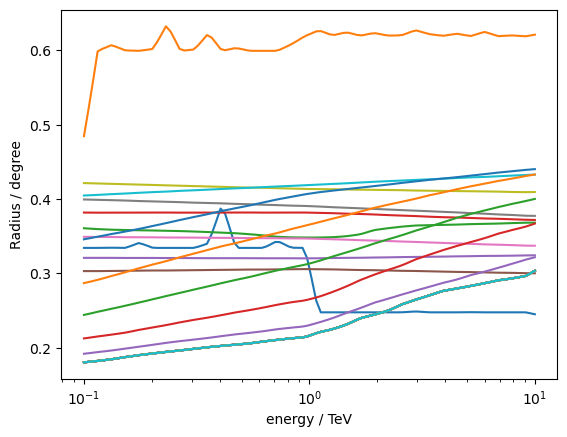

In [411]:
#migra_min , migra_max  = obs1.edisp.axes['migra'].bounds.value
#ereco_events           = obs1.events.energy
#etrue_min , etrue_max   = np.min( ereco_events/ migra_max ), np.max( ereco_events/ migra_min)
etrue                  = np.geomspace( 0.1*u.TeV, 100*u.TeV  ,50)

max_offset         = np.max( events.radec.separation( obs1.pointing_radec) )
offset             = np.linspace( 0*u.deg, max_offset, 50)
cont_radius        = obs1.psf.containment_radius(energy_true=etrue[:,None], offset=offset[None,:], fraction=(0.95))
cont_radius_interp = interpolate.interp2d( etrue, offset, cont_radius)

for o in np.linspace(0,3,30)*u.deg :
    x = np.geomspace(0.1, 10,100)*u.TeV
    y = cont_radius_interp(x,o)

    plt.plot(x,y)
    plt.semilogx()
    plt.xlabel('energy / TeV')
    plt.ylabel('Radius / degree')

# Define the 3-dimensional grid ($E_{true}$, rad, dec) for every observed event

In [412]:
%%time
target_position = SkyCoord(ra=83.63, dec=22.01, unit="deg", frame="icrs")

etrue, detrue                              = build_true_energy( obs1, events)
true_radec, delta_omega, rad, true_offset  = build_true_ra_dec_and_offset( obs1, events,etrue) # , delta_rad 


print( np.shape(etrue) )
print( np.shape(detrue) )
print( np.shape(true_radec))
print( np.shape(delta_omega))
print( np.shape(rad) )
print( np.shape(true_offset) )


(1221, 10, 1, 1)
(1221, 10, 1, 1)
(1221, 10, 15, 15)
(1221, 10, 15, 15)
(1221, 10, 15, 15)
(1221, 10, 15, 15)
CPU times: user 728 ms, sys: 142 ms, total: 870 ms
Wall time: 870 ms


### True Energy Grid

Text(0, 0.5, 'Energy / TeV')

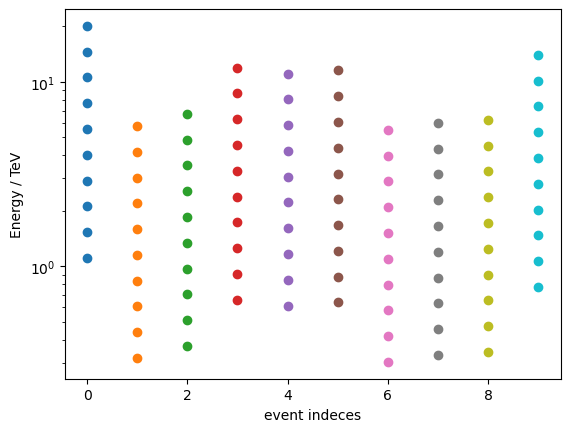

In [428]:
for i_event in range(10):
    y = etrue[i_event,:,0,0]
    x = np.ones_like(y)*i_event
    plt.scatter(x, y)
    plt.semilogy()

plt.xlabel('event indeces')
plt.ylabel('Energy / TeV')

### True Ra,Dec Grid

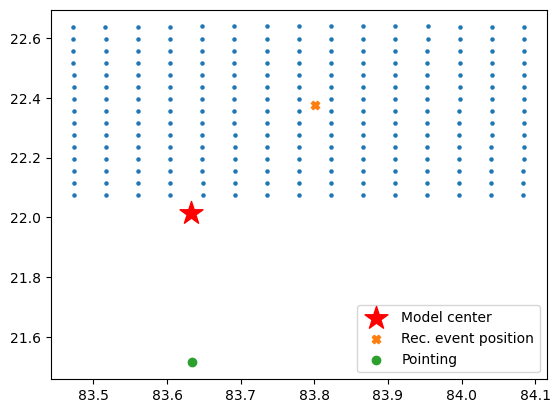

In [429]:
i_event = [210]
x = true_radec[i_event,5,:,:].ra
y = true_radec[i_event,5,:,:].dec
plt.scatter( x,y, s=5 )
    
plt.scatter( model_gauss.position.icrs.ra, model_gauss.position.icrs.dec, marker='*',color='red',s=300,label='Model center')
plt.scatter( events.radec[i_event].ra, events.radec[i_event].dec, marker='X',label='Rec. event position')
plt.scatter( obs1.pointing_radec.ra, obs1.pointing_radec.dec, marker='o', label='Pointing')
plt.legend();

With color coding given by the true energy

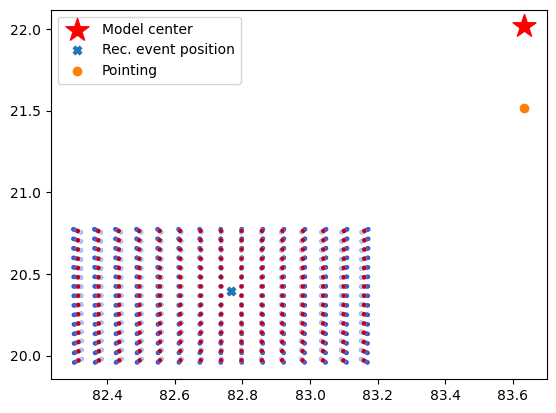

In [430]:
for i_event in [10]:
    all_ra    = []
    all_dec   = []
    all_c = []
    for k,et in enumerate( etrue[i_event,:] ):
        ra  = true_radec[i_event,k,:,:].ra
        dec = true_radec[i_event,k,:,:].dec
        c = np.resize( et, np.shape(x))
        all_ra.append( ra)
        all_dec.append(dec)
        all_c.append( c.value)

    plt.scatter( all_ra,all_dec, s=5, c= all_c, cmap='coolwarm')
    
plt.scatter( model_gauss.position.icrs.ra, model_gauss.position.icrs.dec, marker='*',color='red',s=300,label='Model center')
plt.scatter( events.radec[i_event].ra, events.radec[i_event].dec, marker='X',label='Rec. event position')
plt.scatter( obs1.pointing_radec.ra, obs1.pointing_radec.dec, marker='o', label='Pointing')
plt.legend();

### The radius 'rad' , i.e. the distance from the reconstructed position

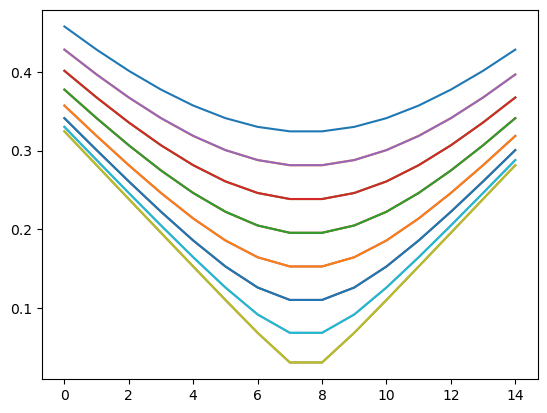

In [431]:
for i_event in [110]:
    for i in range( np.shape(rad)[2]):
        y = rad[i_event,5,i,:]
        y = y.flatten()
        x = np.arange(len(y))
        plt.plot( x, y) #

# We can now build the edisp, aeff, and psf matrices 
# with shape given by (N, e, x, y) where:
- N : total number of events
- e : number of bins in true energy
- x : number of bins in ra coodinate
- y : number of bins in dec coodinate

### The energy dispersion matrix

In [392]:
%%time
edisp                 = make_edisp_factors( obs1, true_offset, etrue,events)
print( np.shape(edisp) )

(1221, 10, 15, 15)
CPU times: user 374 ms, sys: 28.8 ms, total: 403 ms
Wall time: 403 ms


### The effective area matrix

In [432]:
%%time
aeff                  = make_aeff_factors(  obs1, true_offset, etrue)
print( np.shape(aeff) )

(1221, 10, 15, 15)
CPU times: user 213 ms, sys: 22.1 ms, total: 235 ms
Wall time: 234 ms


### The PSF matrix

In [433]:
%%time
psf_factors            = make_psf_factors( obs1, true_offset, etrue, rad)
np.shape( psf_factors )

CPU times: user 451 ms, sys: 26.6 ms, total: 477 ms
Wall time: 477 ms


(1221, 10, 15, 15)

Here we plot the PSF matrix for some events, assuming a given true energy

2.7987732887268066 TeV
1.742950201034546 TeV
4.39040994644165 TeV
2.2802631855010986 TeV
3.0365006923675537 TeV


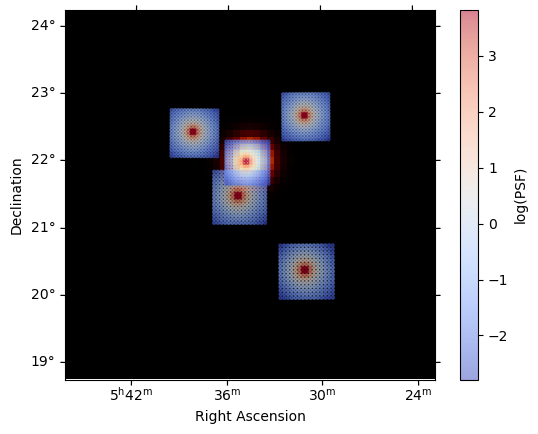

In [440]:
#mapnpred = dataset.evaluators['crab_model_gauss'].compute_npred()
mapnpred = dataset.npred()
model_true=model_gauss.integrate_geom(mapnpred.geom.as_energy_true)
model_true.sum_over_axes().plot()
ax = plt.gca()
for i_event in [485,10,32,21,70]:
    print(events.energy[i_event])
    x = true_radec[i_event,5,:,:].ra.flatten()
    y = true_radec[i_event,5,:,:].dec.flatten()
    c = psf_factors[i_event, 5, :, :].flatten().value
    scatter = ax.scatter( x,y, s=5, c= np.log(c), cmap='coolwarm', transform=ax.get_transform('world'),alpha=0.5)
    
cbar = plt.colorbar(scatter)
cbar.set_label('log(PSF)')


# We can now finally multiply the true flux computed over the grid 3-dimensional grid ($E_{true}$, rad, dec) 
# with the IRF in order t get the flux computed over each event

In [441]:
%%time

phi_obs  = convolve_irf(dataset.models[0], psf_factors, edisp, aeff,  etrue, detrue, true_radec, delta_omega) #, delta_rad)

total_time = obs1.observation_live_time_duration

phi_obs *=  total_time 

print( np.shape( phi_obs) )

(1221,)
CPU times: user 869 ms, sys: 110 ms, total: 979 ms
Wall time: 973 ms


In [442]:
phi_obs.unit

Unit("m2 / (cm2 sr TeV)")

### COMPARISON

In [443]:
ereco_events     = events.energy
lon_events       = events.radec.galactic.l
lat_events       = events.radec.galactic.b
sep_event_model  = events.radec.separation(model_gauss.position)

Text(0, 0.5, ' $\\phi_{obs} \\times E_{reco}$')

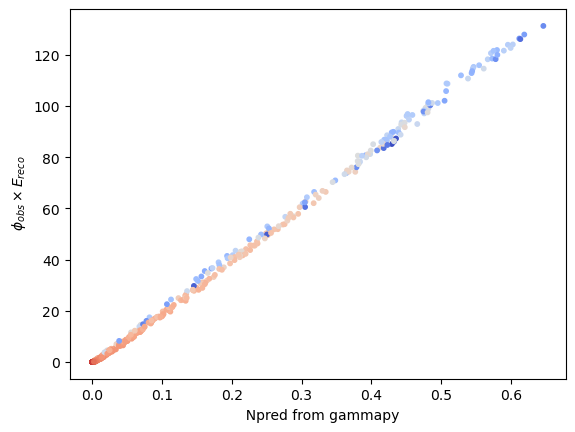

In [444]:
mapnpred = dataset.npred()
ev  = dataset.evaluators['crab_model_gauss']
ev.evaluation_mode='global'
model_gauss.parameters['amplitude'].value*=1.1
mapnpred = dataset.evaluators['crab_model_gauss'].compute_npred()
#mapnpred.data /= mapnpred.geom.bin_volume().value
events_interp = mapnpred.interp_by_coord( events.map_coord( mapnpred.geom ),fill_value=0)

# color coding
c =  sep_event_model.value
#c = ereco_events.value

plt.scatter( events_interp, phi_obs.value*ereco_events.value,  c= np.log(c), cmap='coolwarm', s=10)
plt.xlabel('  Npred from gammapy')
plt.ylabel(r' $\phi_{obs} \times E_{reco}$')

#plt.loglog()

[]

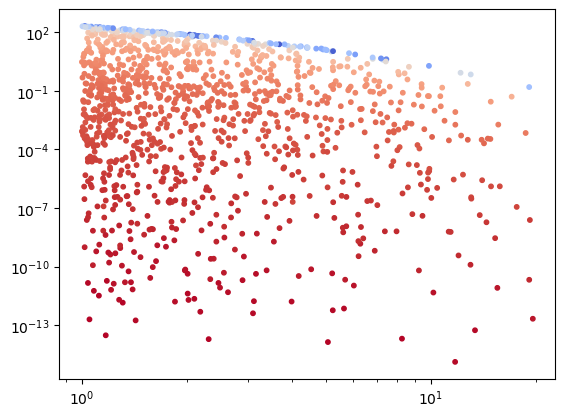

In [139]:


plt.scatter( ereco_events, phi_obs, c= np.log( sep_event_model.value), cmap='coolwarm', s=10)
plt.loglog()
#plt.ylim(1e-0,3e9)

In [70]:
sigma = model_gauss.parameters['sigma'].value * u.deg
position_angle= np.linspace(0,360,100)*u.deg
circle = crab_pos.directional_offset_by(position_angle = position_angle , separation=sigma)

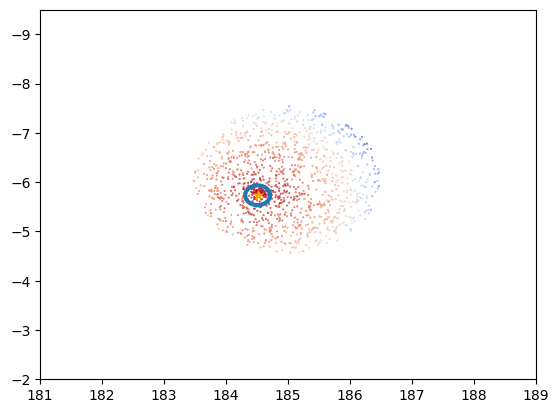

In [71]:
plt.scatter( lon_events, lat_events,s=0.2,    c= np.log10( phi_obs.value ) , cmap='coolwarm')
plt.xlim(181,189)
plt.ylim(-2,-9.5)


plt.scatter(crab_pos.l, crab_pos.b, marker='*', c='orange')
plt.plot( circle.galactic.l,  circle.galactic.b, linewidth=3)

# RECONSTRUCTED = TRUE

[]

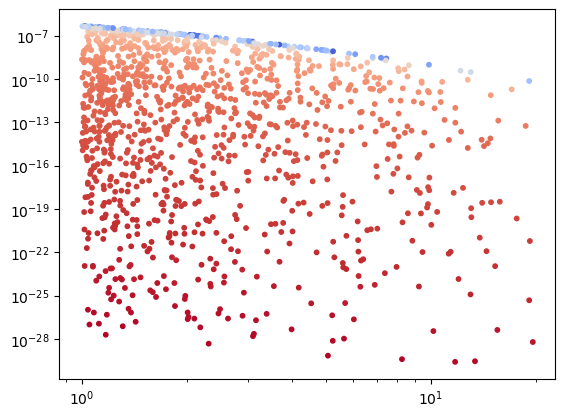

In [72]:
phi_true         = dataset.models[0]( energy= ereco_events, lon= lon_events, lat = lat_events)

plt.scatter( ereco_events, phi_true ,c= np.log( sep_event_model.value), cmap='coolwarm', s=10)
plt.loglog()
#plt.ylim(1e-0,3e9)

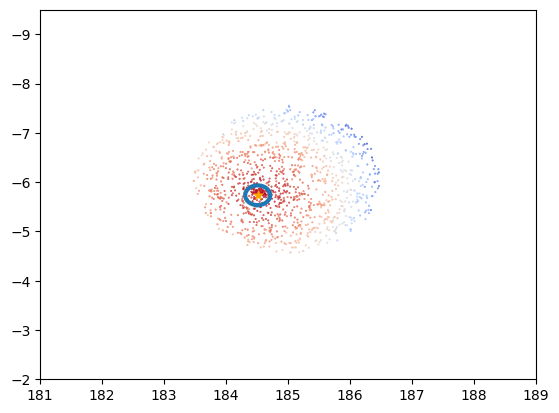

In [73]:
plt.scatter( lon_events, lat_events,    c= np.log10( phi_true.value ) ,s=0.2,  cmap='coolwarm')
plt.xlim(181,189)
plt.ylim(-2,-9.5)
plt.scatter(crab_pos.l, crab_pos.b, marker='*', c='orange')
plt.plot( circle.galactic.l,  circle.galactic.b, linewidth=3)

# GAMMAPY NPRED

In [74]:
mapnpred = dataset.npred()
ev  = dataset.evaluators['crab_model_gauss']
ev.evaluation_mode='global'
model_gauss.parameters['amplitude'].value*=1.1
mapnpred = dataset.evaluators['crab_model_gauss'].compute_npred()
#mapnpred.data /= mapnpred.geom.bin_volume().value
events_interp = mapnpred.interp_by_coord( events.map_coord( mapnpred.geom ),fill_value=0)


<WCSAxesSubplot:xlabel='Right Ascension', ylabel='Declination'>

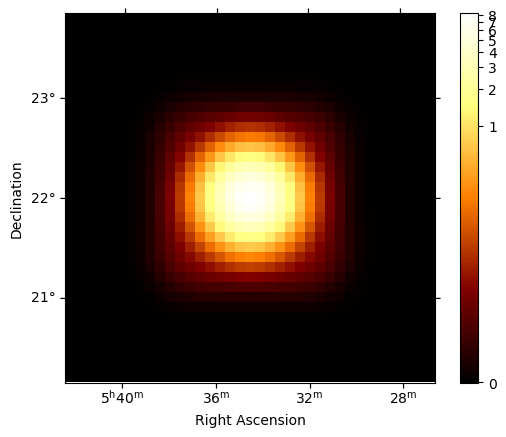

In [75]:
mapnpred.sum_over_axes().plot(add_cbar=True,stretch='log')

[]

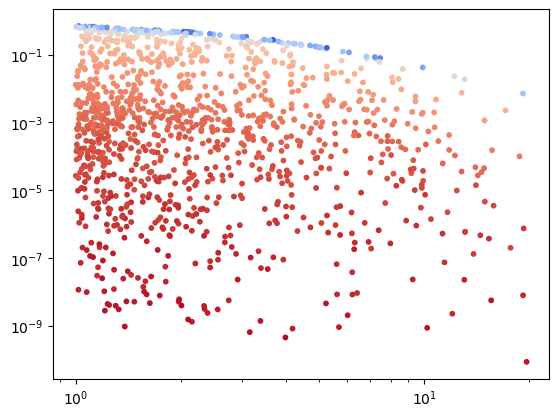

In [76]:
plt.scatter(  ereco_events, events_interp, c= np.log( sep_event_model.value), cmap='coolwarm', s=10)
#plt.semilogx()
plt.loglog()

In [77]:
circle = crab_pos.directional_offset_by(position_angle = position_angle , separation=sigma)

/var/folders/cc/9yrg3qln5sq119c30p8bh2h00000gn/T/ipykernel_60487/1772660466.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter( lon_events, lat_events, s=0.2,   c= np.log10( events_interp ) , cmap='coolwarm')
/var/folders/cc/9yrg3qln5sq119c30p8bh2h00000gn/T/ipykernel_60487/1772660466.py:1: RuntimeWarning: invalid value encountered in log10
  plt.scatter( lon_events, lat_events, s=0.2,   c= np.log10( events_interp ) , cmap='coolwarm')


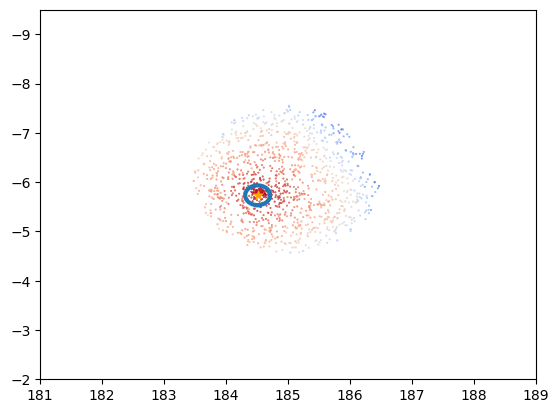

In [78]:
plt.scatter( lon_events, lat_events, s=0.2,   c= np.log10( events_interp ) , cmap='coolwarm')
plt.xlim(181,189)
plt.ylim(-2,-9.5)
plt.scatter(crab_pos.l, crab_pos.b, marker='*', c='orange')
plt.plot( circle.galactic.l,  circle.galactic.b, linewidth=3)